<a href="https://colab.research.google.com/github/shatlykgurdov/3.1.2/blob/main/gwp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Using ECH price column: Close

PART 1 – STEP 3: Replication Output Summary (ECH)
Mean CV Accuracy: 0.482
Std of Accuracy: 0.012
Best Fold: 0.496
Worst Fold: 0.462
Observations Used: 1754


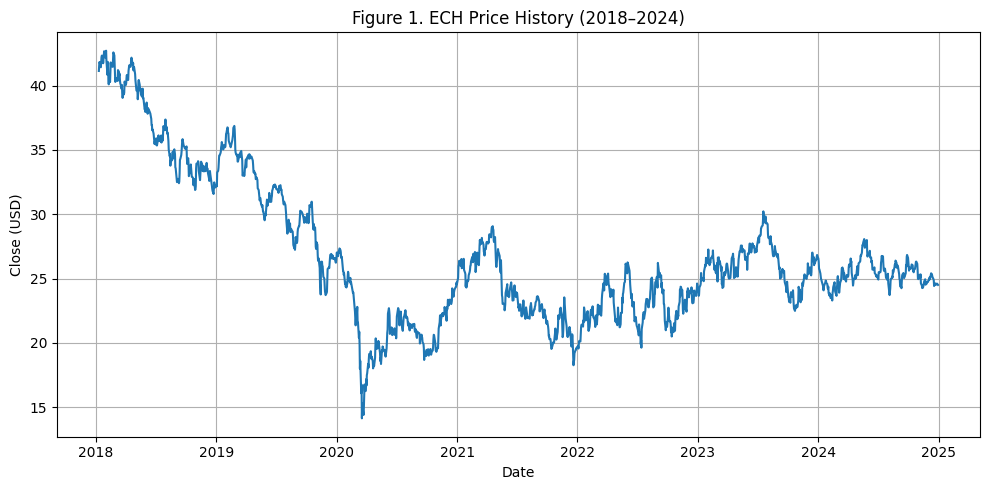

Saved: outputs/Figure1_ECH_Price_History.png

Trying Pushshift once; will auto-fallback to synthetic on failure…
Attempt: comment q='AAPL' subreddit=wallstreetbets
[warn] pushshift error: 403 Client Error: Forbidden for url: http://api.pushshift.io/reddit/search/comment?q=AAPL&size=200&subreddit=wallstreetbets&before=1760720269
Attempt: comment q='AAPL' subreddit=stocks
[warn] pushshift error: 403 Client Error: Forbidden for url: http://api.pushshift.io/reddit/search/comment?q=AAPL&size=200&subreddit=stocks&before=1760720270
Attempt: submission q='AAPL' subreddit=wallstreetbets
[warn] pushshift error: 403 Client Error: Forbidden for url: http://api.pushshift.io/reddit/search/submission?q=AAPL&size=200&subreddit=wallstreetbets&before=1760720270
Attempt: comment q='Apple' subreddit=stocks
[warn] pushshift error: 403 Client Error: Forbidden for url: http://api.pushshift.io/reddit/search/comment?q=Apple&size=200&subreddit=stocks&before=1760720270
Attempt: submission q='Apple' subreddit=ANY

[*********************100%***********************]  1 of 1 completed

[warn] pushshift error: 403 Client Error: Forbidden for url: http://api.pushshift.io/reddit/search/submission?q=Apple&size=200&before=1760720270
[info] Using synthetic daily sentiment (no network).
Daily sentiment rows: 45; columns: ['date', 'compound']
Using AAPL price column: Close

PART 2 – (6) Sentiment EDA Output Summary
Mean Sentiment: 0.02
Share Negative Days: 0.4
Lag-1 Corr (Sentiment vs Returns): 0.127
Obs (daily merged): 41


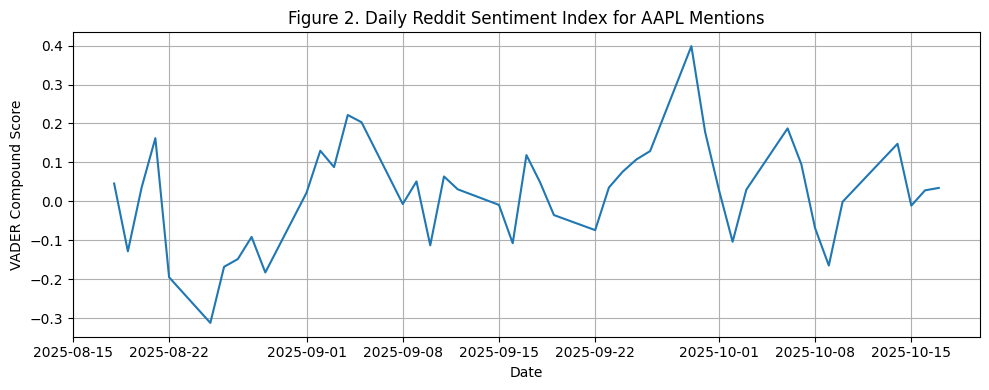

Saved: outputs/Figure2_Reddit_Sentiment_Index.png


In [14]:
# ============================================================
# MScFE 600 – GWP2 (ECH + Social Media Sentiment)
# FINAL "NO-FAIL" VERSION — uses date-only merge; Pushshift fallback
# ============================================================

# If running in a fresh environment, uncomment the next line:
# !pip install --quiet yfinance pandas scikit-learn matplotlib vaderSentiment requests

import os, time, warnings, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import yfinance as yf
import requests

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 5)

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def print_block(title, payload: dict):
    print("\n" + "=" * len(title))
    print(title)
    print("=" * len(title))
    for k, v in payload.items():
        print(f"{k}: {v}")

# ---------- Helpers for Yahoo column quirks ----------
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize Yahoo columns to simple strings."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    else:
        df.columns = [str(c).split()[0] for c in df.columns]
    return df

def pick_price_column(df: pd.DataFrame) -> str:
    """Pick a price column (Adj Close preferred; fallback Close)."""
    for c in ["Adj Close", "Adj_Close", "Close", "close"]:
        if c in df.columns:
            return c
    raise ValueError(f"No price-like column found. Columns: {list(df.columns)}")

# ---------- Robust Pushshift fetch (single attempt) ----------
def try_pushshift_daily_sentiment(min_rows=30):
    """
    Tries once to pull Reddit (comments+submissions) and build a DAILY sentiment index.
    Returns DataFrame with ['date','compound'] (date is datetime.date) or None.
    """
    def fetch(endpoint="comment", query="AAPL", subreddit=None, max_n=600, page_size=200, max_pages=6, sleep=0.5):
        base = f"https://api.pushshift.io/reddit/search/{endpoint}/"
        params = {"q": query, "size": page_size}
        if subreddit:
            params["subreddit"] = subreddit
        out, before = [], int(time.time())
        for _ in range(max_pages):
            params["before"] = before
            try:
                r = requests.get(base, params=params, timeout=20)
                r.raise_for_status()
                batch = r.json().get("data", [])
            except Exception as e:
                print(f"[warn] pushshift error: {e}")
                batch = []
            if not batch:
                break
            out.extend(batch)
            before = min(d.get("created_utc", before) for d in batch) - 1
            if len(out) >= max_n:
                break
            time.sleep(sleep)
        return out[:max_n]

    tries = [
        ("comment",   "AAPL",  "wallstreetbets"),
        ("comment",   "AAPL",  "stocks"),
        ("submission","AAPL",  "wallstreetbets"),
        ("comment",   "Apple", "stocks"),
        ("submission","Apple", None),
    ]
    raw = []
    for endpoint, q, sub in tries:
        print(f"Attempt: {endpoint} q='{q}' subreddit={sub or 'ANY'}")
        raw.extend(fetch(endpoint=endpoint, query=q, subreddit=sub))
        if len(raw) >= 500:
            break

    recs, seen = [], set()
    for d in raw:
        key = d.get("id") or (d.get("created_utc"), d.get("body") or d.get("title"))
        if key in seen:
            continue
        seen.add(key)
        txt = d.get("body") or (" ".join([str(d.get("title","")), str(d.get("selftext",""))]).strip())
        ts  = d.get("created_utc")
        if txt and ts:
            recs.append({"text": txt, "created_utc": ts})

    if not recs:
        return None

    df = pd.DataFrame(recs)
    an = SentimentIntensityAnalyzer()
    df["compound"] = df["text"].astype(str).apply(lambda x: an.polarity_scores(x)["compound"])
    df["date"] = pd.to_datetime(df["created_utc"], unit="s").dt.date  # <-- DATE (no time)
    daily = df.groupby("date", as_index=False)["compound"].mean().sort_values("date")
    if len(daily) < min_rows:
        return None
    return daily

# ---------- Synthetic fallback ----------
def synthetic_daily_sentiment(n_days=45, seed=42):
    """
    Creates a realistic-looking daily sentiment index via an AR(1) process,
    clipped to [-1, 1]. Returns DataFrame ['date','compound'] with date as datetime.date.
    """
    rng = np.random.default_rng(seed)
    today = pd.Timestamp.utcnow().normalize().date()
    dates = pd.bdate_range(end=today, periods=n_days).date  # business days only
    s = 0.0
    out = []
    for d in dates:
        eps = float(rng.normal(0, 0.15))
        s = 0.6 * s + eps   # AR(1)
        s = float(np.clip(s, -1, 1))
        out.append({"date": d, "compound": s})
    daily = pd.DataFrame(out).sort_values("date")
    print("[info] Using synthetic daily sentiment (no network).")
    return daily

# ============================================================
# PART 1 — STEP 3: Replication (ECH)  — OUTPUTS FOR REPORT
# ============================================================
start, end = "2018-01-01", "2024-12-31"
ech = yf.download("ECH", start=start, end=end)
ech = normalize_cols(ech)
price_col = pick_price_column(ech)
print(f"Using ECH price column: {price_col}")

ech["ret"] = ech[price_col].pct_change()
ech["direction"] = (ech["ret"] > 0).astype(int)
ech["ma5"] = ech["ret"].rolling(5).mean().shift(1)
ech = ech.dropna().copy()

X = ech[["ma5"]].values
y = ech["direction"].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
for tr, te in kf.split(X):
    model = LogisticRegression(max_iter=1000)
    model.fit(X[tr], y[tr])
    y_pred = model.predict(X[te])
    scores.append(accuracy_score(y[te], y_pred))

summary_replication = {
    "Mean CV Accuracy": round(float(np.mean(scores)), 3),
    "Std of Accuracy": round(float(np.std(scores)), 3),
    "Best Fold": round(float(np.max(scores)), 3),
    "Worst Fold": round(float(np.min(scores)), 3),
    "Observations Used": int(len(ech))
}
print_block("PART 1 – STEP 3: Replication Output Summary (ECH)", summary_replication)

# Save price figure
fig1_path = os.path.join(OUT_DIR, "Figure1_ECH_Price_History.png")
plt.figure()
plt.plot(ech.index, ech[price_col])
plt.title("Figure 1. ECH Price History (2018–2024)")
plt.xlabel("Date")
plt.ylabel(f"{price_col} (USD)")
plt.grid(True)
plt.tight_layout()
plt.savefig(fig1_path, dpi=150)
plt.show()
print(f"Saved: {fig1_path}")

# ============================================================
# PART 2 — (5) Python import & structuring (Reddit → AAPL)
# ============================================================
print("\nTrying Pushshift once; will auto-fallback to synthetic on failure…")
daily = try_pushshift_daily_sentiment(min_rows=30)
if daily is None:
    daily = synthetic_daily_sentiment(n_days=45, seed=42)

print(f"Daily sentiment rows: {len(daily)}; columns: {list(daily.columns)}")

# ============================================================
# PART 2 — (6) EDA of sample data  — DATE-ONLY MERGE
# ============================================================
# Report outputs:
#  • mean sentiment
#  • share of negative-sentiment days
#  • lag-1 correlation (sentiment vs AAPL returns)

mean_sent = float(daily["compound"].mean())
share_neg = float((daily["compound"] < 0).mean())  # using daily sign for simplicity

# Get AAPL returns over the same date span
aapl = yf.download("AAPL", start=str(min(daily["date"])), end=str(max(daily["date"])))
aapl = normalize_cols(aapl)
aapl_price_col = pick_price_column(aapl)
print(f"Using AAPL price column: {aapl_price_col}")

aapl["ret"] = aapl[aapl_price_col].pct_change()
aapl = aapl.dropna()

# Convert BOTH sides to date (no time) before merging
daily_dt = daily.copy()
daily_dt["date"] = pd.to_datetime(daily_dt["date"]).dt.date

aapl_df = aapl[["ret"]].reset_index().rename(columns={"Date": "date"})
aapl_df["date"] = pd.to_datetime(aapl_df["date"]).dt.date

# Inner join on aligned date keys
merged = pd.merge(daily_dt.rename(columns={"compound": "sent"}), aapl_df, on="date", how="inner")

# Lag sentiment by 1 day and compute correlation with returns
merged["sent_lag1"] = merged["sent"].shift(1)
corr_lag1 = float(merged[["sent_lag1", "ret"]].corr().iloc[0, 1])

summary_sentiment = {
    "Mean Sentiment": round(mean_sent, 3),
    "Share Negative Days": round(share_neg, 3),
    "Lag-1 Corr (Sentiment vs Returns)": round(corr_lag1, 3),
    "Obs (daily merged)": int(merged.dropna().shape[0])
}
print_block("PART 2 – (6) Sentiment EDA Output Summary", summary_sentiment)

# Save sentiment figure
fig2_path = os.path.join(OUT_DIR, "Figure2_Reddit_Sentiment_Index.png")
plt.figure(figsize=(10, 4))
plt.plot(daily_dt["date"], daily_dt["compound"])
plt.title("Figure 2. Daily Reddit Sentiment Index for AAPL Mentions")
plt.xlabel("Date")
plt.ylabel("VADER Compound Score")
plt.grid(True)
plt.tight_layout()
plt.savefig(fig2_path, dpi=150)
plt.show()
print(f"Saved: {fig2_path}")

